In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [2]:
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# use gpu if cuda is available
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

- __tuple__ - static list
- __deterministic__ - no randomness in future states

In [3]:
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a transition"""""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

### The model

In [4]:
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Input extraction
Extract and process rendered images from the envirionment. Uses __```torchvision```__ pakage

/opt/anaconda3-4.4.0/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


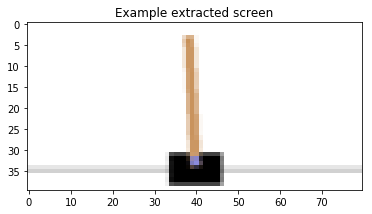

In [5]:
resize = T.Compose([T.ToPILImage(),
                   T.Scale(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

# This is based on the code from gym. Or so they said.
screen_width = 600

def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) # MIDDLE of CART

def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1)) # transpose into torch order (CHW)?
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                           cart_location + view_width // 2)
    # Strip off the edges, so that we hav ea square image centered on a cart
    screen = screen[:,:,slice_range]
    # convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy? lol)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    #Resize, add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

### Training
#### Hyperparameters and utilities
Instantiates the defined model and its optimizer, and defines some utilities



In [13]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1,1)
    else:
        return LongTensor([[random.randrange(2)]])
    
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episodes averages and plot them too lol
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001) # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

#### Training loop
optimizer function does it job..

In [14]:
last_sync = 0

def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                         batch.next_state)))
    # Something about no backprop through the expected action values and volatile
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                               if s is not None]),
                                    volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    #Now, we dont want to mess up the loss with a volatile flag, so let's clear it. After this, we'll just end up with a Variable that has requires_grad=False
    next_state_values.volatile = False
    # Conpute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

Main training loop

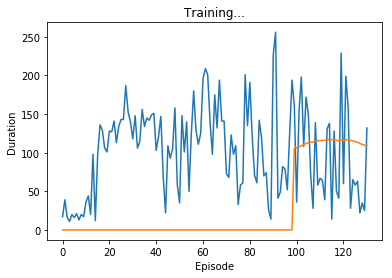

RuntimeError: the given numpy array has zero-sized dimensions. Zero-sized dimensions are not supported in PyTorch

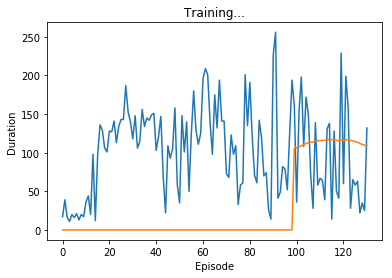

In [15]:
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done,_ = env.step(action[0,0])
        reward = Tensor([reward])
        
        # Observe new state
        last_screen = current_screen 
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        #Moveto the next state
        state = next_state
        
        #Perform one step of the optimization ( on the target network)
        optimize_model()
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
            
print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()

In [19]:
for g_ in (gym.envs.registry.all()):
    print(g_)

EnvSpec(SolarisNoFrameskip-v0)
EnvSpec(TimePilot-ramDeterministic-v0)
EnvSpec(Seaquest-ramNoFrameskip-v4)
EnvSpec(ChopperCommand-ram-v0)
EnvSpec(BreakoutNoFrameskip-v4)
EnvSpec(AirRaid-ramNoFrameskip-v0)
EnvSpec(NameThisGameNoFrameskip-v0)
EnvSpec(Freeway-v4)
EnvSpec(Pooyan-ramNoFrameskip-v4)
EnvSpec(Solaris-ramDeterministic-v4)
EnvSpec(SpaceInvadersDeterministic-v0)
EnvSpec(Zaxxon-ramNoFrameskip-v0)
EnvSpec(Carnival-v0)
EnvSpec(Hero-ramNoFrameskip-v0)
EnvSpec(Amidar-ramNoFrameskip-v4)
EnvSpec(UpNDown-ram-v0)
EnvSpec(KungFuMasterDeterministic-v0)
EnvSpec(Frostbite-ram-v4)
EnvSpec(Robotank-v4)
EnvSpec(Breakout-ram-v4)
EnvSpec(YarsRevengeDeterministic-v0)
EnvSpec(KrullNoFrameskip-v0)
EnvSpec(Qbert-v4)
EnvSpec(YarsRevengeNoFrameskip-v4)
EnvSpec(FrostbiteNoFrameskip-v0)
EnvSpec(Freeway-ram-v0)
EnvSpec(Atlantis-ram-v4)
EnvSpec(Skiing-ramNoFrameskip-v4)
EnvSpec(PrivateEye-ram-v0)
EnvSpec(HeroDeterministic-v4)
EnvSpec(Asterix-v0)
EnvSpec(Hero-v4)
EnvSpec(Robotank-v0)
EnvSpec(KrullDeterministi